In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import shap

## **Merge All Files**

In [ ]:
# import pandas as pd

# # Upload all files
# crop_params = pd.read_csv("/content/CropParameters.csv")
# GreenhouseClimate = pd.read_csv("/content/GreenhouseClimate-New.csv")
# GrodanSens = pd.read_csv("/content/GrodanSens-New.csv")
# lab_analysis = pd.read_csv("/content/LabAnalysis.csv")
# production = pd.read_csv("/content/Production.csv")
# resources = pd.read_csv("/content/Resources.csv")
# tom_quality = pd.read_csv("/content/TomQuality.csv")

# # Merge data based on `Time`
# merged_df = crop_params.merge(lab_analysis, on="Time", how="outer")
# merged_df = merged_df.merge(GreenhouseClimate, on="Time", how="outer")
# merged_df = merged_df.merge(GrodanSens, on="Time", how="outer")
# merged_df = merged_df.merge(production, on="Time", how="outer")
# merged_df = merged_df.merge(resources, on="Time", how="outer")
# merged_df = merged_df.merge(tom_quality, on="Time", how="outer")


# merged_df.to_csv("merged_data.csv", index=False)

### **Files worked on **

In [ ]:

crop = pd.read_csv("/content/CropParameters.csv")
greenhouse = pd.read_csv("/content/GreenhouseClimate-New.csv")
lab_analysis = pd.read_csv("/content/LabAnalysis.csv")
resources = pd.read_csv("/content/Resources.csv")



df = crop.merge(greenhouse, on="Time", how="inner")\
         .merge(lab_analysis, on="Time", how="inner")\
         .merge(resources, on="Time", how="inner")


# Convert 'Tot_PAR' column to numeric, handling errors
df['Tot_PAR'] = pd.to_numeric(df['Tot_PAR'], errors='coerce')

# Convert relevant columns to numeric before calculation
df['Tair'] = pd.to_numeric(df['Tair'], errors='coerce')
df['Rhair'] = pd.to_numeric(df['Rhair'], errors='coerce')
df['Drain'] = pd.to_numeric(df['Drain'], errors='coerce')

#  Evapotranspiration (ET)
df["Evapotranspiration"] = (0.408 * (df["Tot_PAR"] - 0) +
                             (900 / (df["Tair"] + 273)) * (df["Rhair"] / 100) * df["Drain"]) / \
                           (1 + 0.34 * df["Drain"])

#  EC Total
df["EC_Total"] = df["irr_EC"] - (df["drain_EC"] * (df["Drain"] / df["Irr"]))

df.to_csv("final_merged_data.csv", index=False)

<ipython-input-181-ef777e831f9f>:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,20,22,23,25,27,29,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  greenhouse = pd.read_csv("/content/GreenhouseClimate-New.csv")
<ipython-input-181-ef777e831f9f>:8: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df = crop.merge(greenhouse, on="Time", how="inner")\


In [2]:
df = pd.read_csv("/content/work_merged_data .csv")

### **EDA**

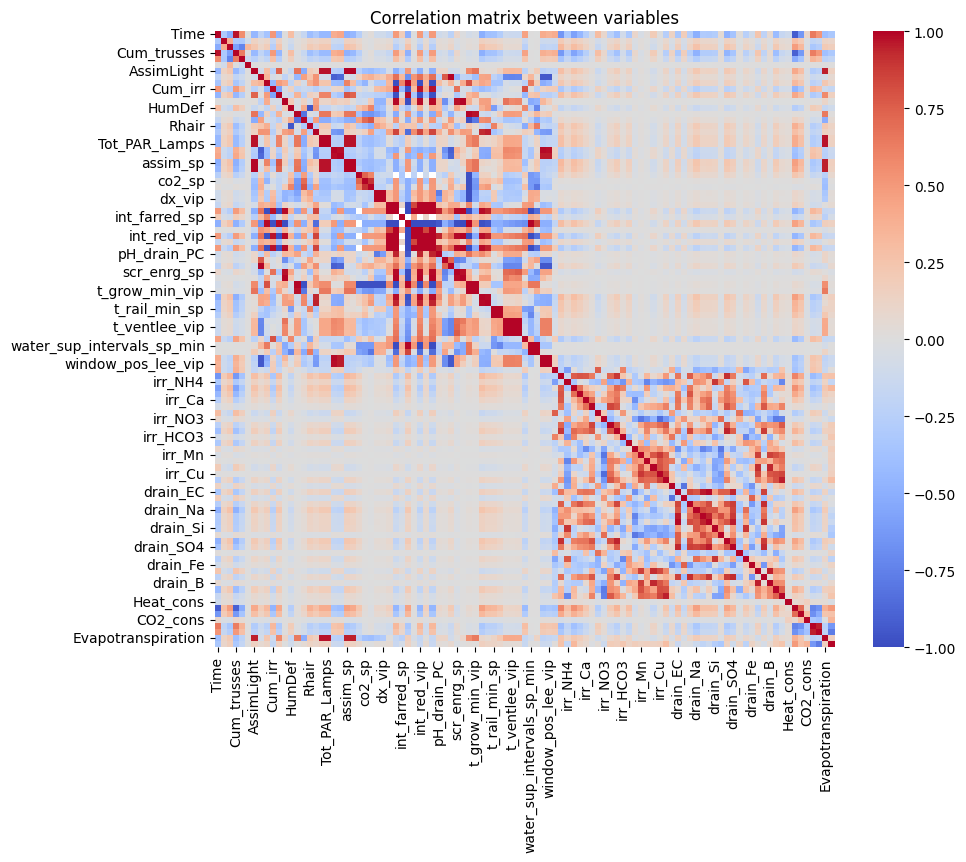

In [ ]:
# Analysis of the relationship between variables (correlation matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix between variables")
plt.show()

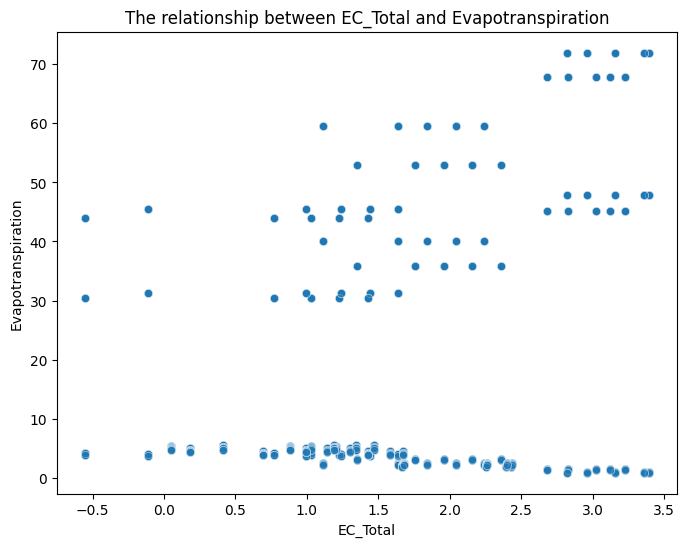

In [ ]:
#Drawing the relationship between EC_Total and ET
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["EC_Total"], y=df["Evapotranspiration"], alpha=0.6)
plt.title("The relationship between EC_Total and Evapotranspiration")
plt.xlabel("EC_Total")
plt.ylabel("Evapotranspiration")
plt.show()

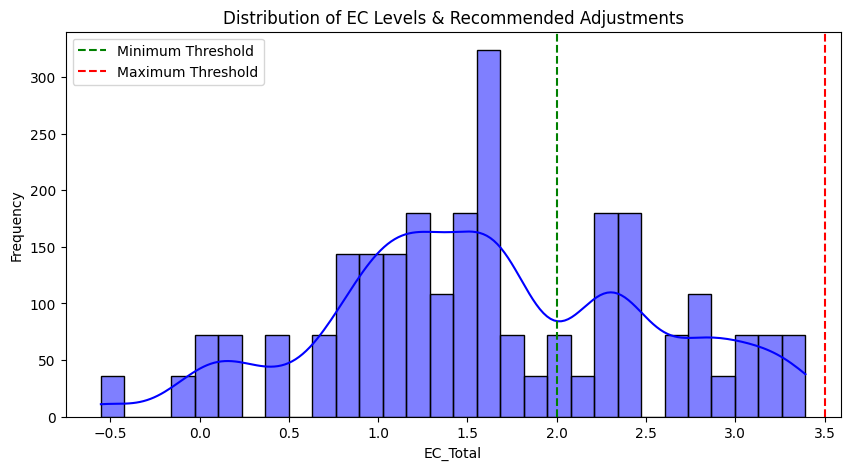

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df["EC_Total"], bins=30, kde=True, color='blue')
plt.axvline(x=2.0, color='green', linestyle='--', label="Minimum Threshold")
plt.axvline(x=3.5, color='red', linestyle='--', label="Maximum Threshold")
plt.title("Distribution of EC Levels & Recommended Adjustments")
plt.xlabel("EC_Total")
plt.ylabel("Frequency")
plt.legend()
plt.show()

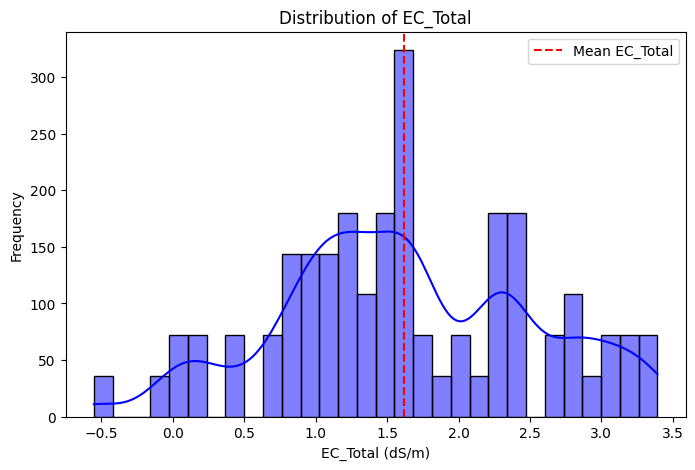

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df["EC_Total"], kde=True, bins=30, color="blue")
plt.title("Distribution of EC_Total")
plt.xlabel("EC_Total (dS/m)")
plt.ylabel("Frequency")
plt.axvline(df["EC_Total"].mean(), color='red', linestyle='--', label="Mean EC_Total")
plt.legend()
plt.show()

<Figure size 3500x2500 with 0 Axes>

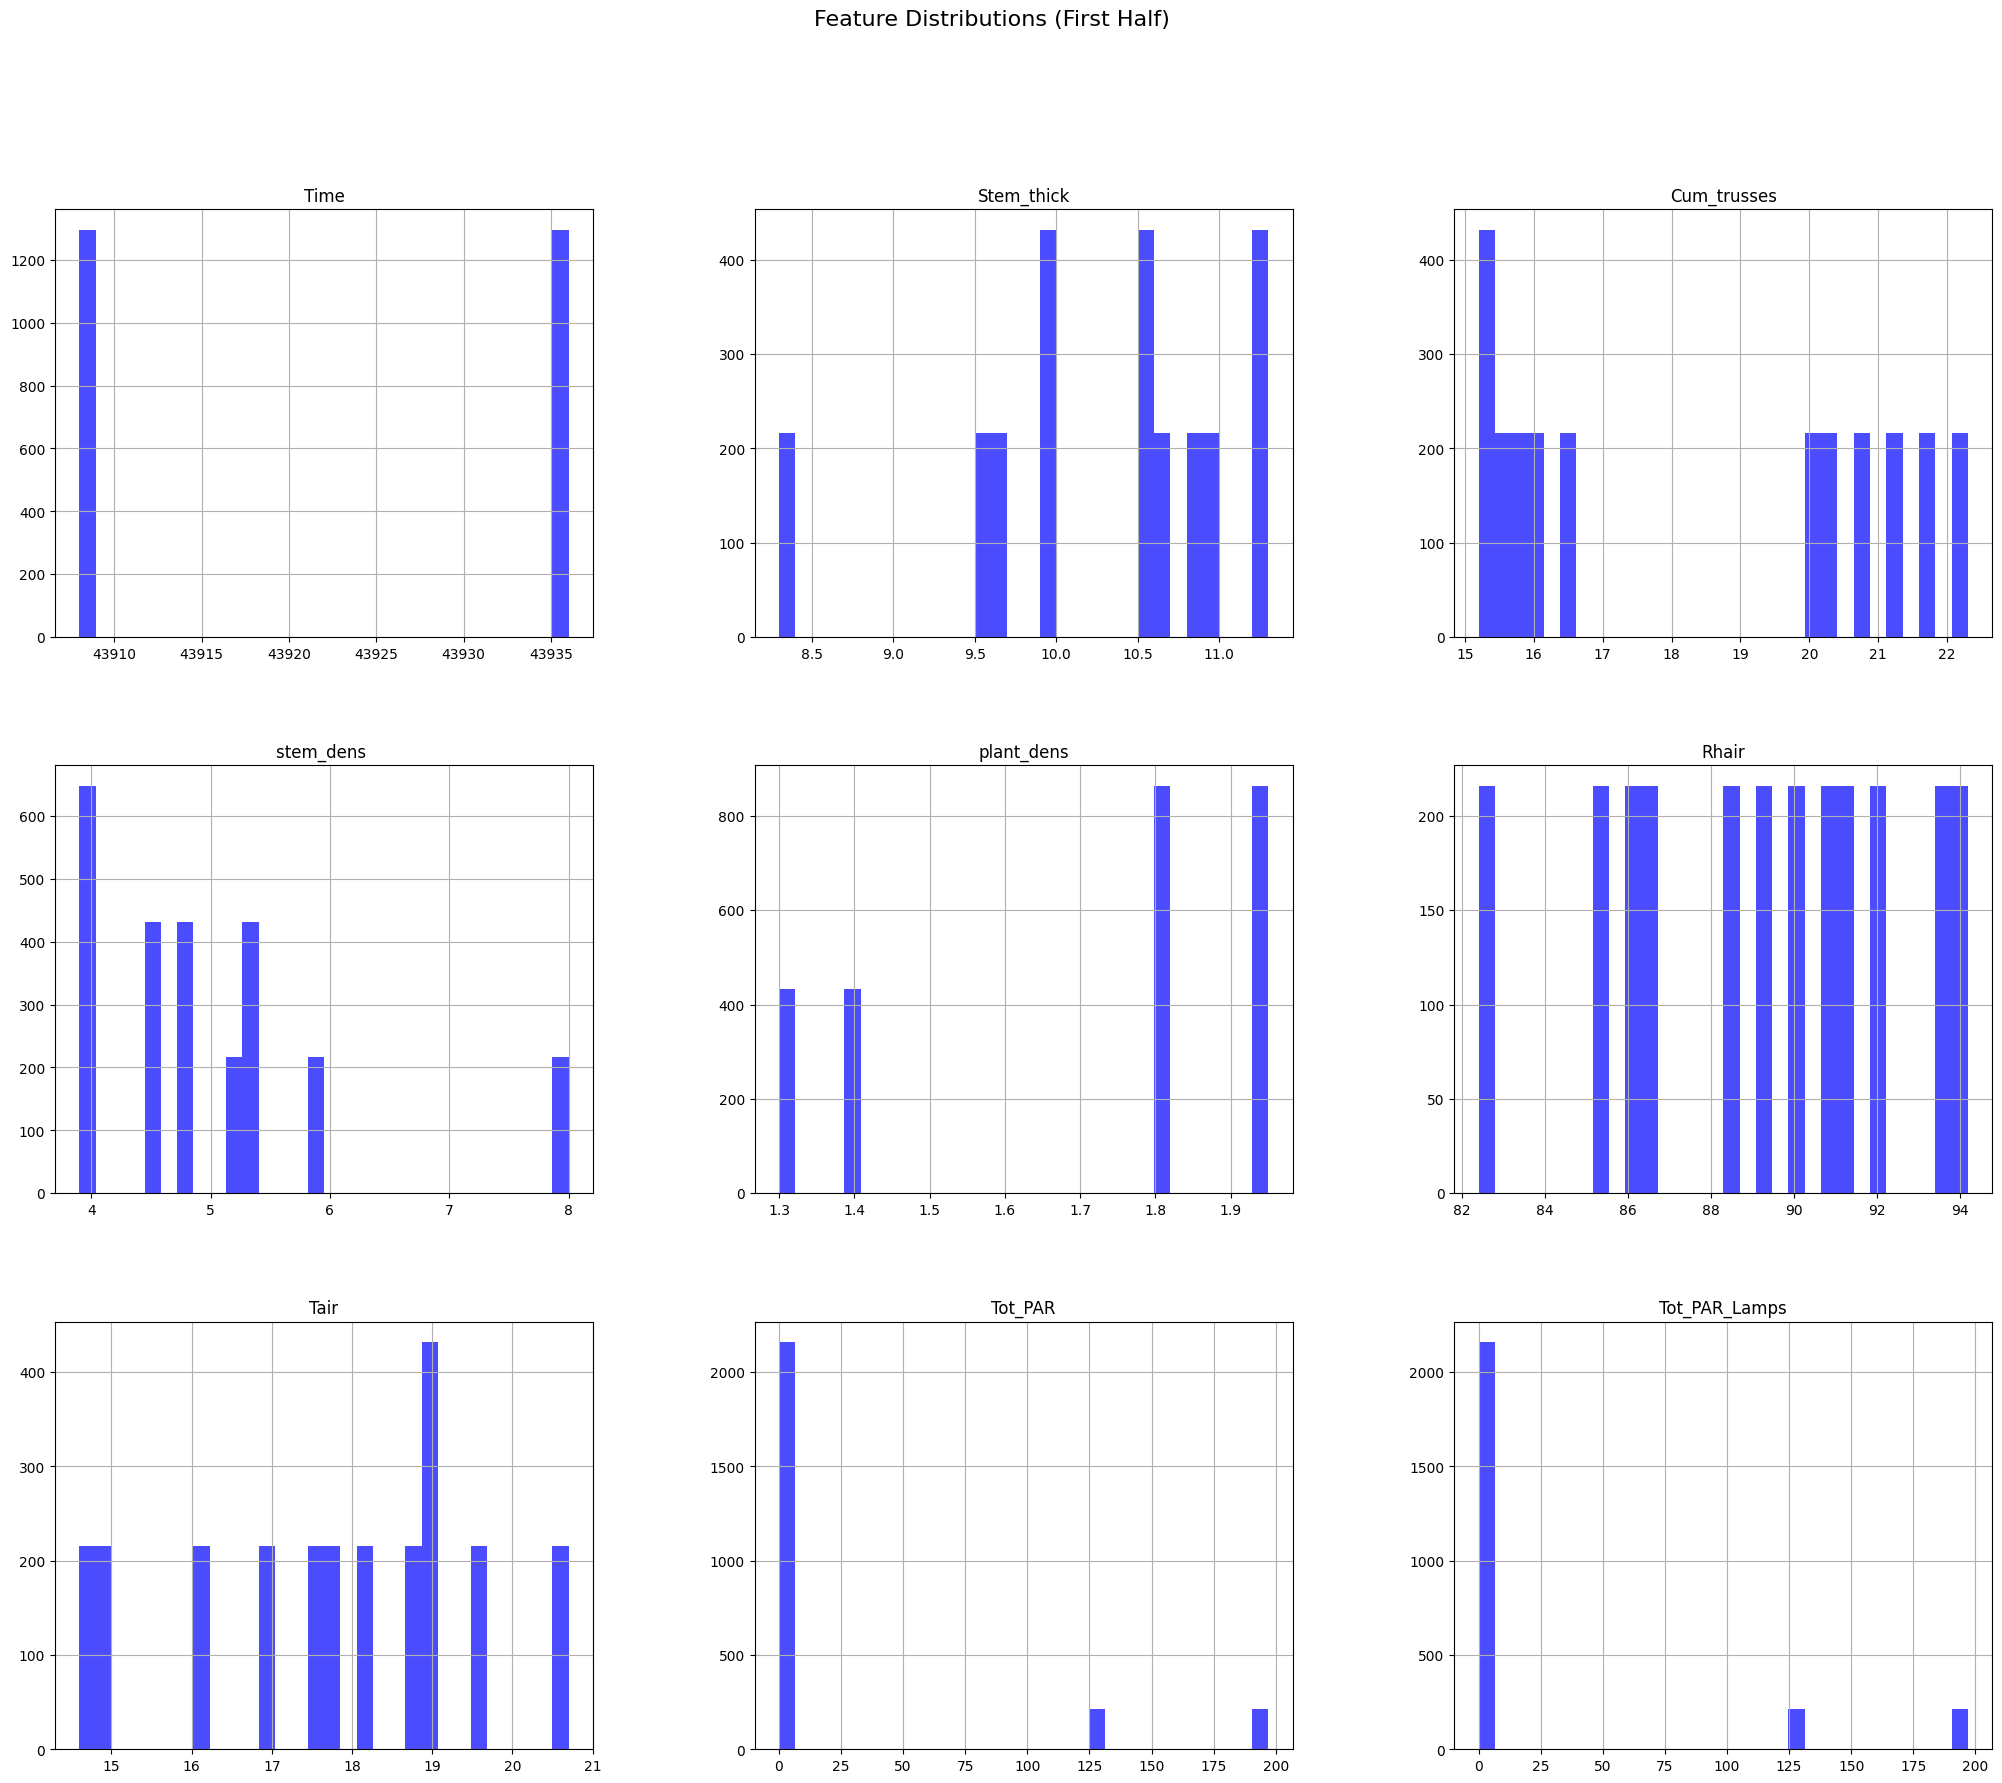

<Figure size 3500x2500 with 0 Axes>

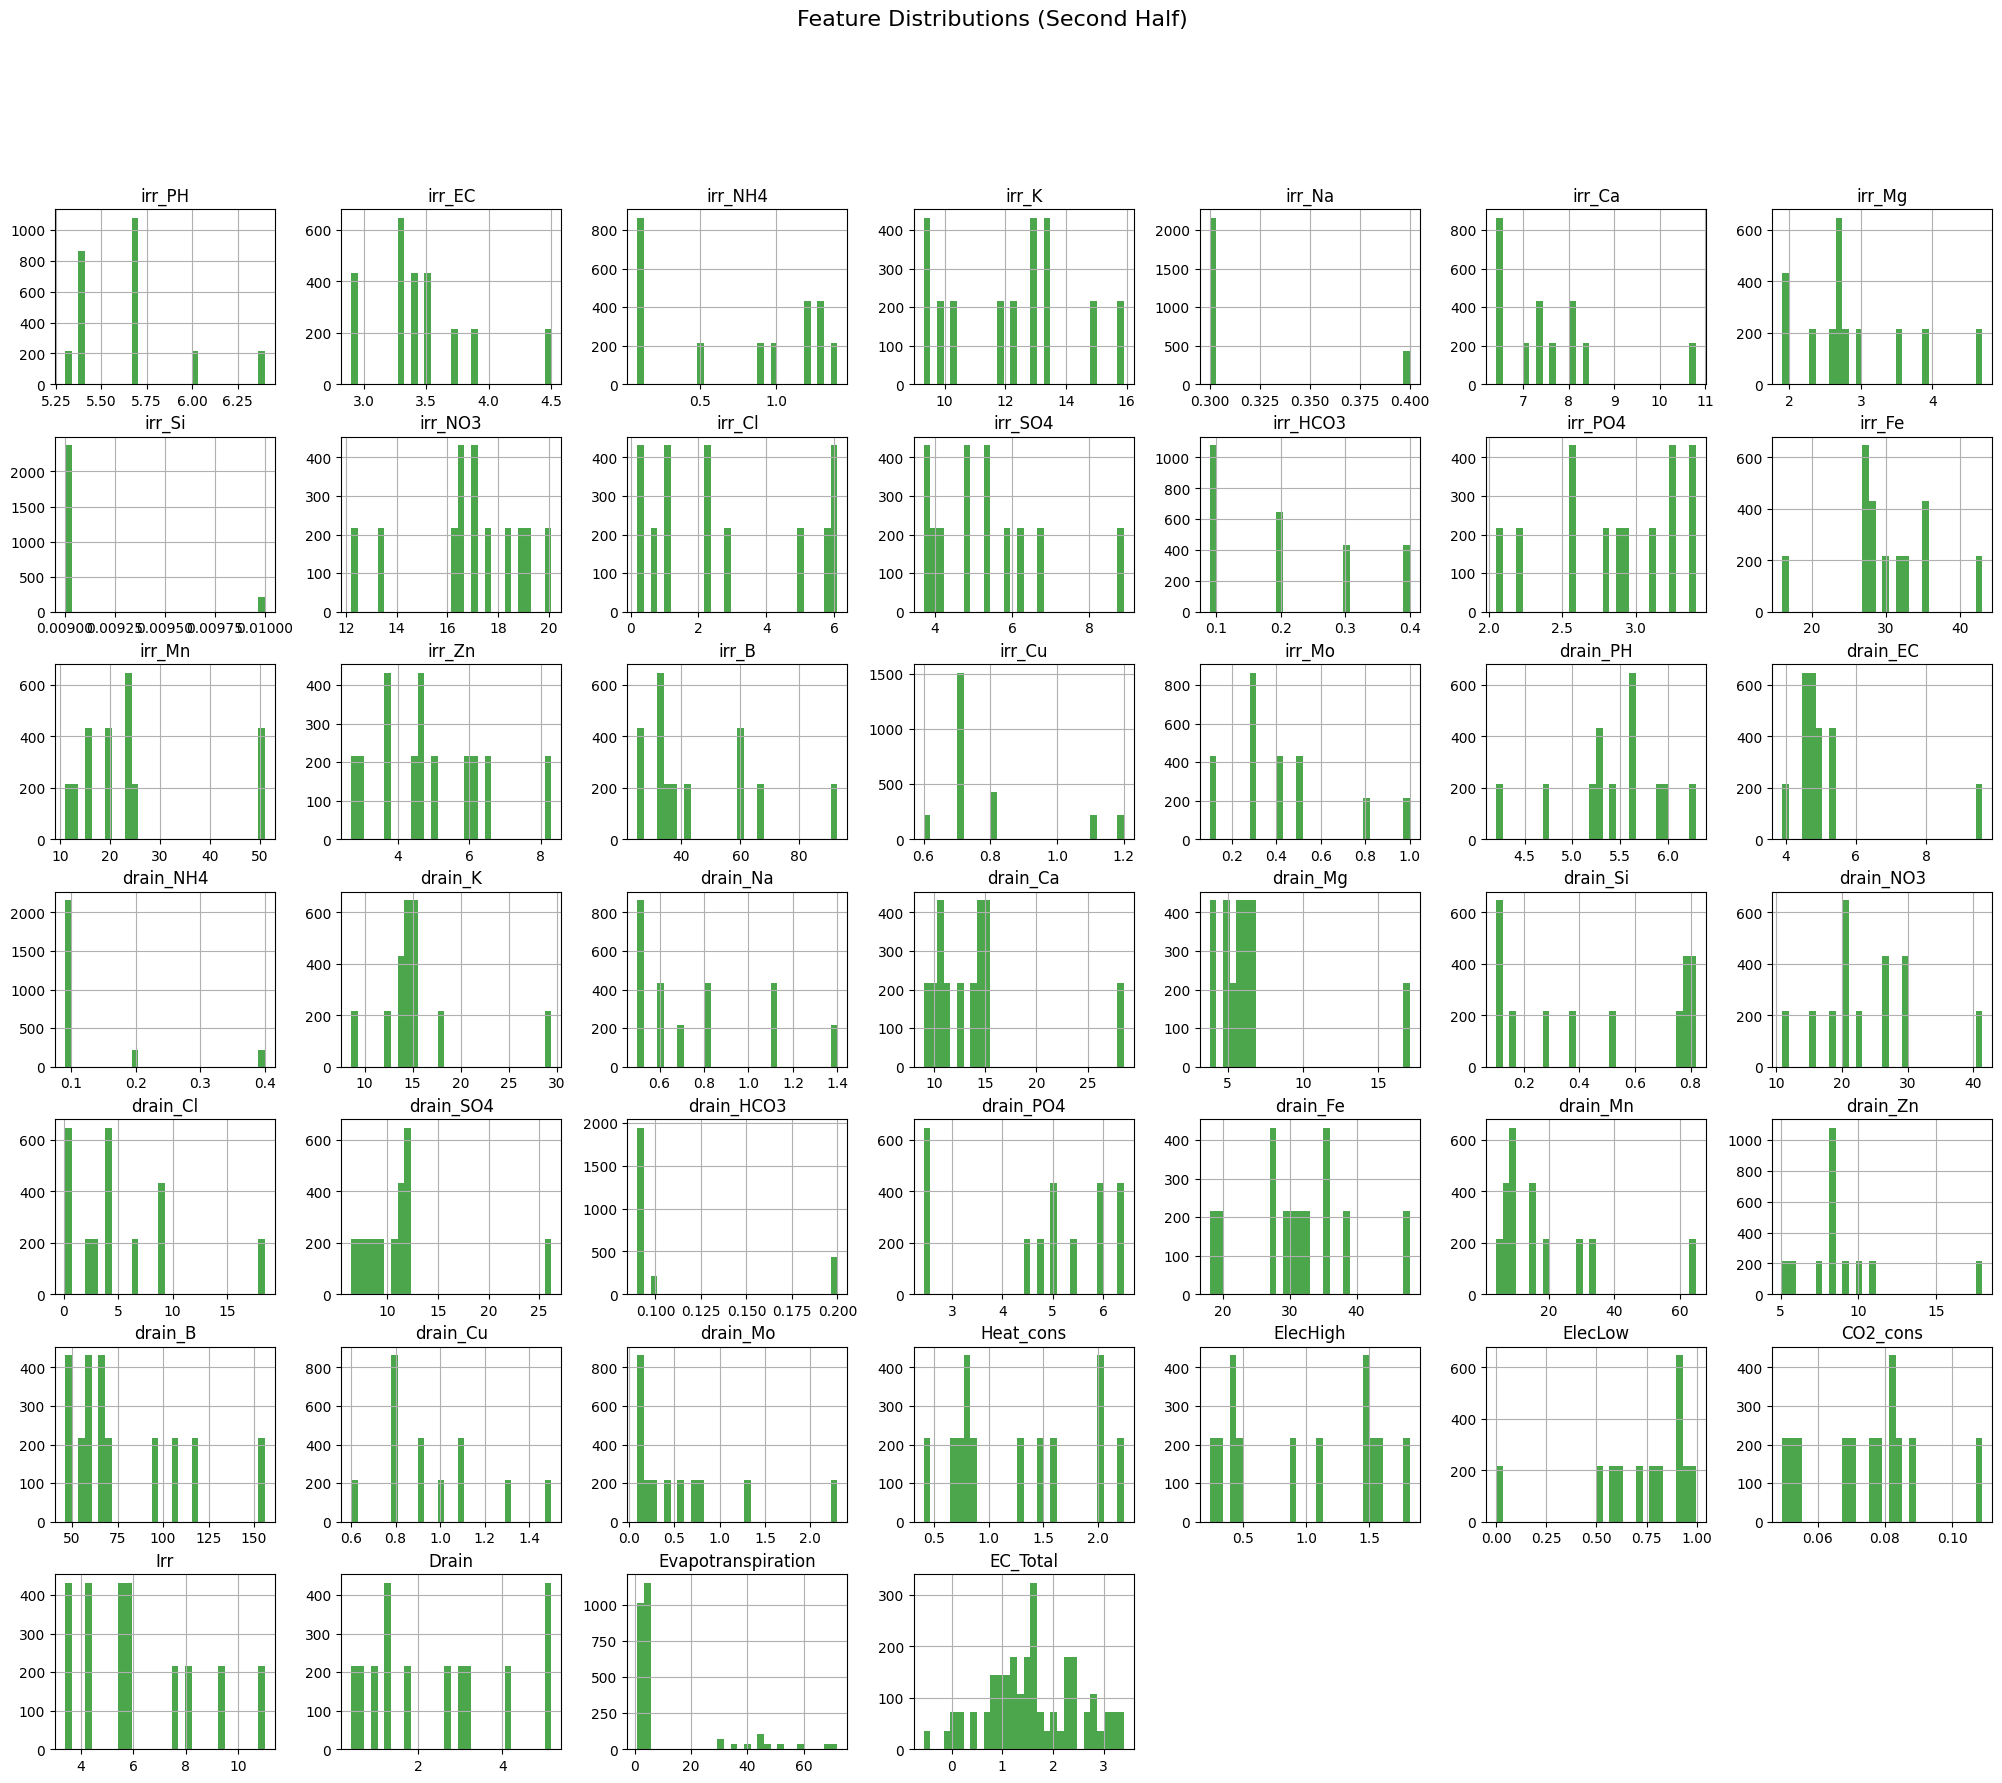

In [ ]:
num_features = len(df.columns)
mid_index = num_features // 2

first_half = df.iloc[:, :mid_index]
second_half = df.iloc[:, mid_index:]


plt.figure(figsize=(35, 25))
first_half.hist(figsize=(25, 20), bins=30, color="blue", alpha=0.7)
plt.suptitle("Feature Distributions (First Half)", fontsize=16)
plt.show()


plt.figure(figsize=(35, 25))
second_half.hist(figsize=(25, 20), bins=30, color="green", alpha=0.7)
plt.suptitle("Feature Distributions (Second Half)", fontsize=16)
plt.show()

### **Perprocessing**

In [ ]:
df.isnull().sum()

,0
Time,0
Stem_elong,0
Stem_thick,0
Cum_trusses,0
stem_dens,0
...,...
CO2_cons,0
Irr,0
Drain,0
Evapotranspiration,0


In [ ]:
df.shape

(2592, 101)

In [3]:
df_filled = df.select_dtypes(include=np.number).fillna(df.select_dtypes(include=np.number).mean())

In [ ]:
df_filled.isnull().sum()

,0
Time,0
Stem_thick,0
Cum_trusses,0
stem_dens,0
plant_dens,0
Rhair,0
Tair,0
Tot_PAR,0
Tot_PAR_Lamps,0
irr_PH,0


In [ ]:
df.shape

(2592, 20)

In [4]:
df.columns = df.columns.str.lower().str.strip()

### **Manual features selection**

In [5]:

#  Column cleaning (removing spaces and unifying letters)
df.columns = df.columns.str.lower().str.strip()

#  Selected features
selected_features = [
    "irr_ph", "irr_ec", "drain_ph", "drain_ec", "drain_no3", "drain_k", "drain_ca", "drain_mg", "drain_na",
    "tair", "rhair", "tot_par", "co2air",
    "stem_elong", "stem_thick", "cum_trusses",
    "irr", "drain"
]

#  Exclude unwanted columns
target_columns = ["ec_total", "evapotranspiration"]
df = df[selected_features + target_columns]

# Convert 'co2air' and 'stem_elong' to numeric
# If they contain non-numeric values, handle them appropriately (e.g., replace with NaN or a specific value)
for col in ["co2air", "stem_elong"]:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # 'coerce' will replace non-numeric values with NaN

# You can then fill NaN values with the mean
df.fillna(df.mean(), inplace=True)

<ipython-input-5-96d280c2b859>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')  # 'coerce' will replace non-numeric values with NaN
<ipython-input-5-96d280c2b859>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)


In [6]:
X = df[selected_features]
y = df[target_columns]

#  Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

results = []

#  Training each model and evaluating performance
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": name, "MAE": mae, "MSE": mse, "R2": r2})

               Model       MAE       MSE        R2
0  Linear Regression  1.200238  6.777717  0.916622
1      Random Forest  0.001250  0.000017  0.999988
2            XGBoost  0.000805  0.000002  1.000000


<ipython-input-195-b84aa652589e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R2", data=results_df, palette="coolwarm")


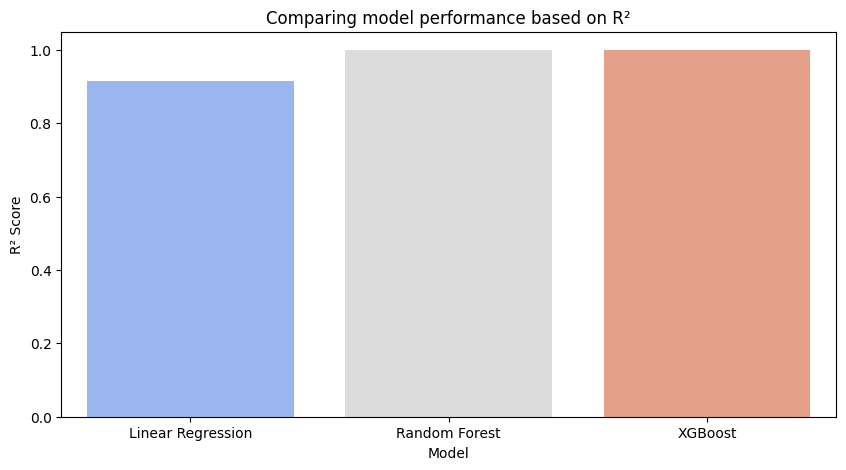

In [ ]:
results_df = pd.DataFrame(results)

print(results_df)

plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="R2", data=results_df, palette="coolwarm")
plt.title("Comparing model performance based on R²")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.show()

### **Automatic feature selection using mutual_info_regression**

<ipython-input-8-5db2deed4ca5>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


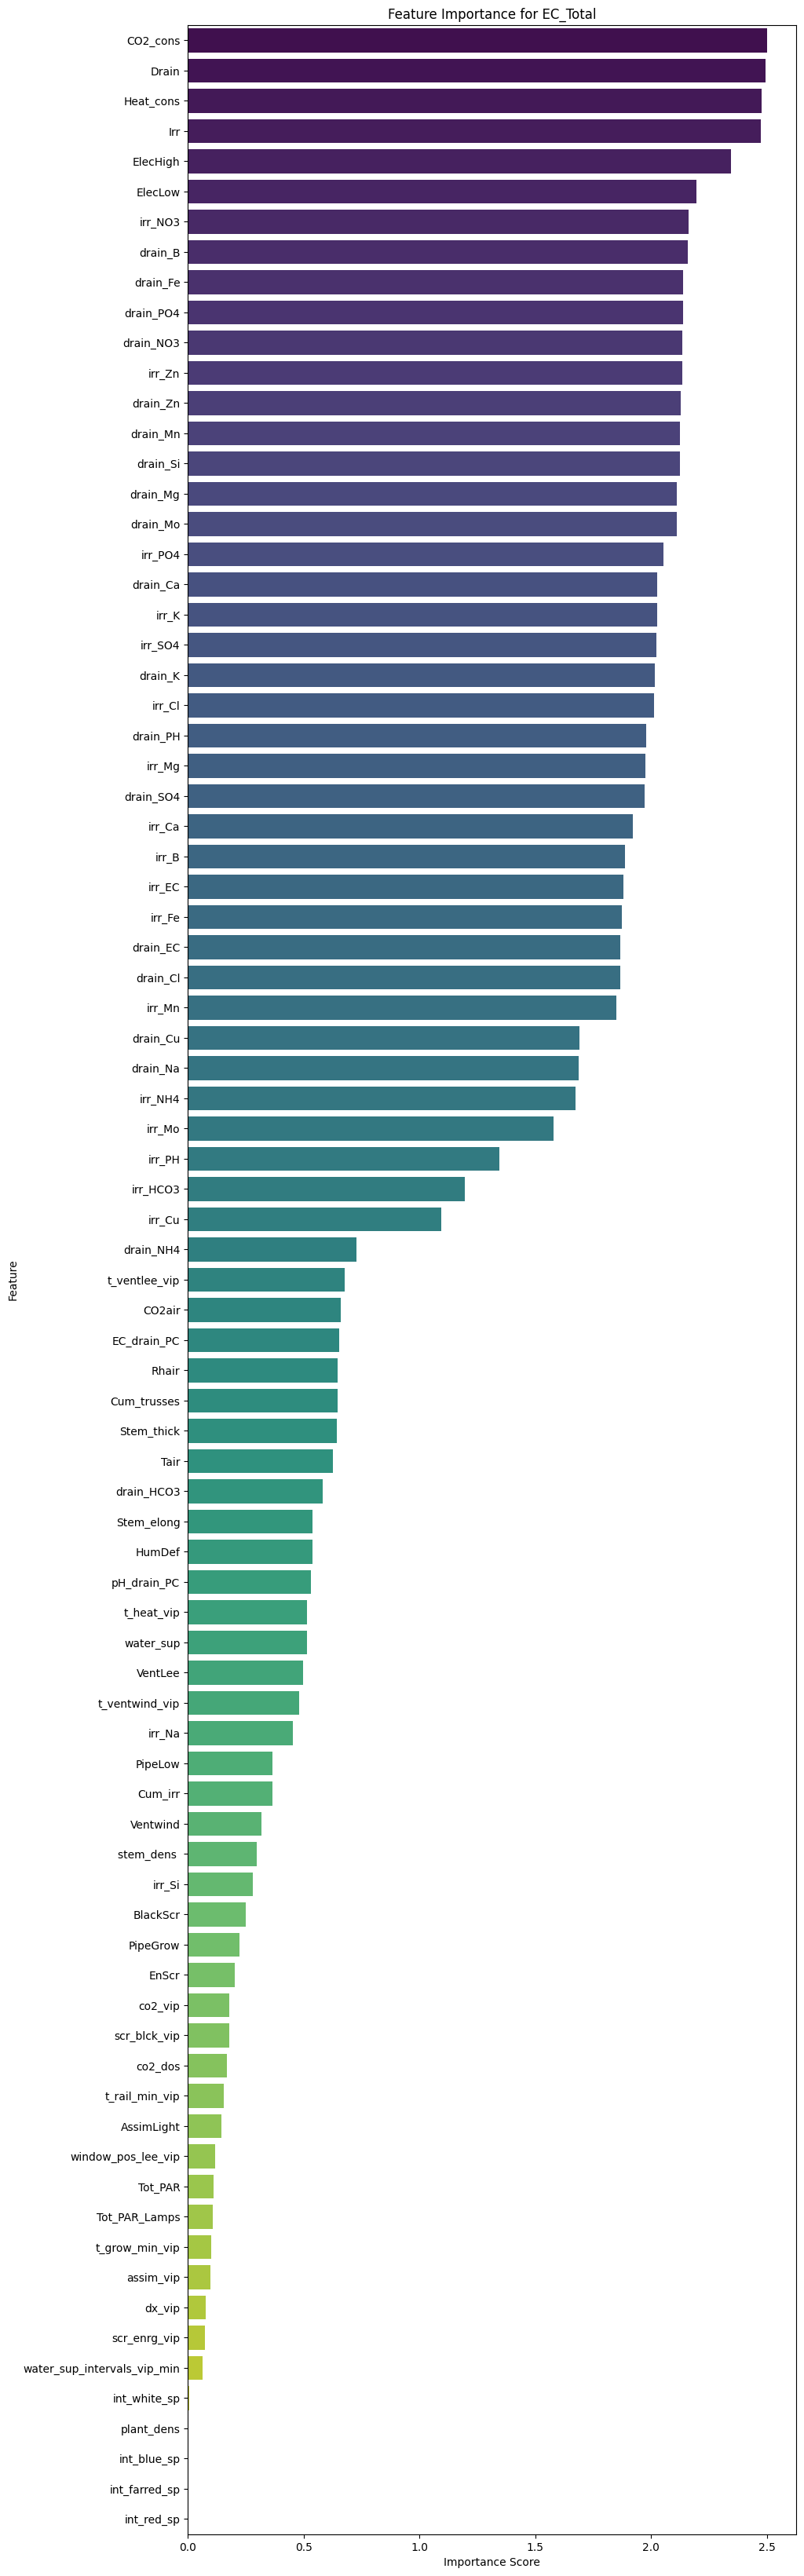

<ipython-input-8-5db2deed4ca5>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


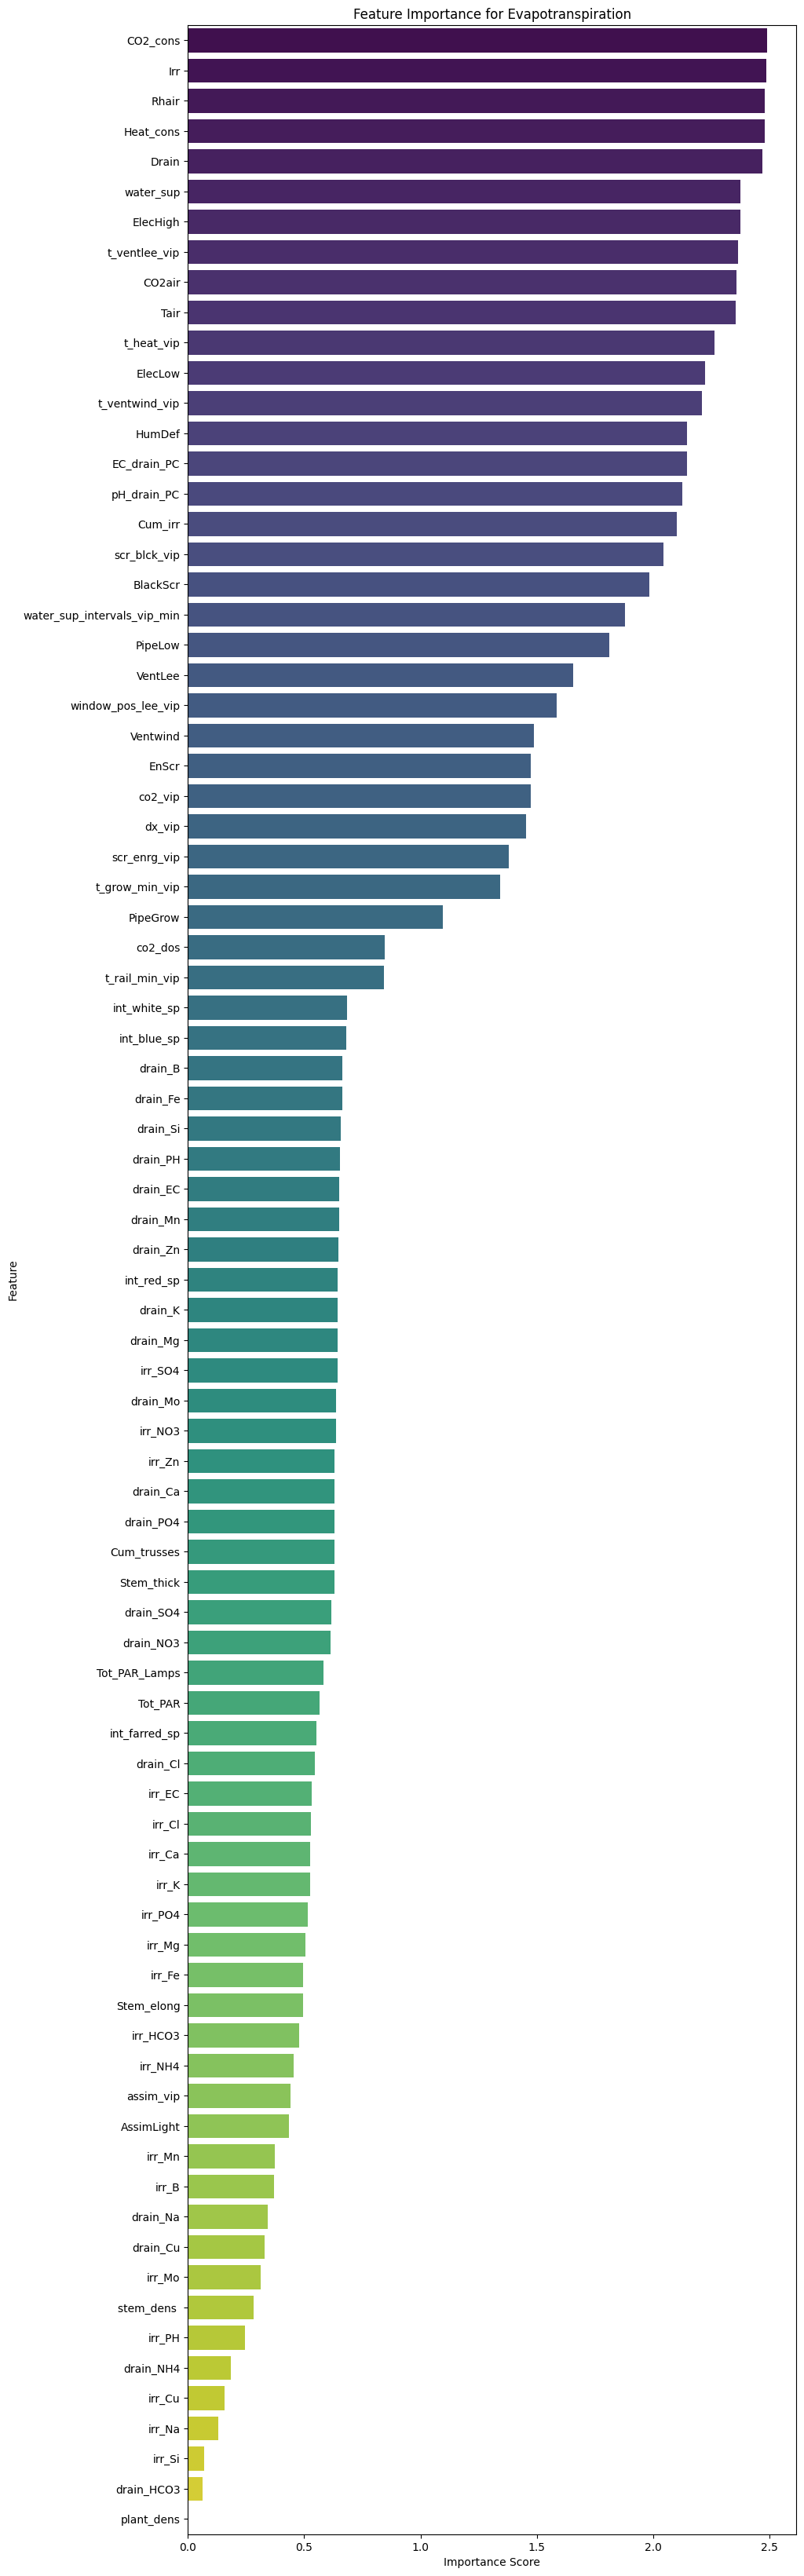

In [8]:
# Automatically select features excluding "Time", "EC_Total", and "ET"
excluded_columns = ["Time", "EC_Total", "Evapotranspiration"]
features = df_filled.drop(columns=[col for col in excluded_columns if col in df_filled.columns])

#  Calculate feature importance for each target (EC_Total and ET)
targets = ["EC_Total", "Evapotranspiration"]
for target in targets:
    if target in df_filled.columns:
        y = df_filled[target]

       # Calculate importance using mutual_info_regression
        importance = mutual_info_regression(features, y)


        importance_df = pd.DataFrame({"Feature": features.columns, "Importance": importance})
        importance_df = importance_df.sort_values(by="Importance", ascending=False)


        plt.figure(figsize=(10, len(importance_df) * 0.5))
        sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
        plt.title(f"Feature Importance for {target}")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.show()

In [9]:
# Splitting data into training and testing
X = df_filled[features.columns]  # Use df_filled instead of df
y = df_filled[["EC_Total", "Evapotranspiration"]]  # Use df_filled instead of df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# List of models we will try
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

results = []

In [11]:
# Test each model and calculate the performance.
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": name, "MAE": mae, "MSE": mse, "R2": r2})

               Model       MAE           MSE        R2
0  Linear Regression  1.213779  6.551777e+00  0.921336
1      Random Forest  0.001220  1.709636e-05  0.999985
2            XGBoost  0.000411  4.100358e-07  1.000000


<ipython-input-12-5079ecf0432a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R2", data=results_df, palette="coolwarm")


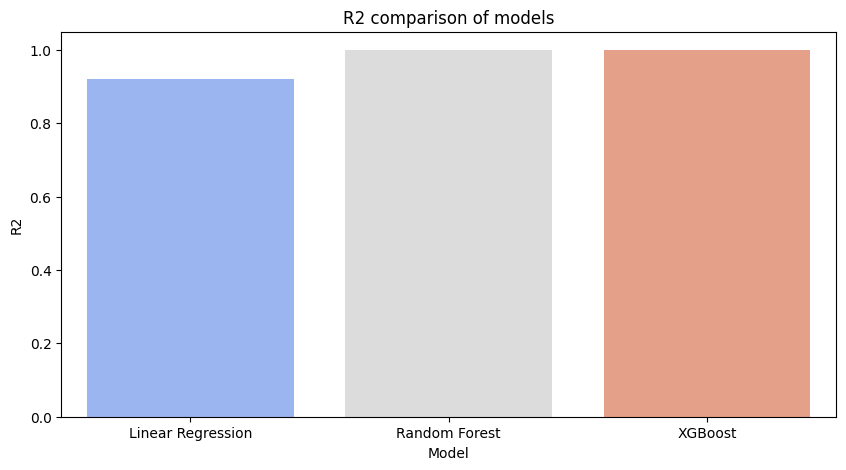

In [12]:
results_df = pd.DataFrame(results)


print(results_df)

# Comparison of model performance
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="R2", data=results_df, palette="coolwarm")
plt.title("R2 comparison of models")
plt.show()

In [13]:
# Select the best model based on the highest R2
best_model_name = results_df.sort_values(by="R2", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

In [14]:
# Training the model on the entire data
best_model.fit(X, y)


future_predictions = best_model.predict(X_test)


predictions_df = pd.DataFrame(future_predictions, columns=["Predicted_EC_Total", "Predicted_ET"])
predictions_df["Actual_EC_Total"] = y_test["EC_Total"].values
predictions_df["Actual_ET"] = y_test["Evapotranspiration"].values

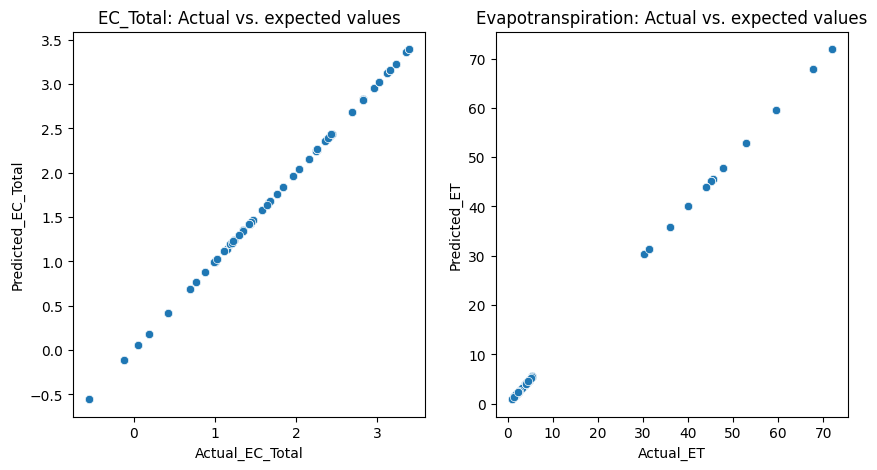

In [ ]:
# Comparison between actual and expected values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=predictions_df["Actual_EC_Total"], y=predictions_df["Predicted_EC_Total"])
plt.title("EC_Total: Actual vs. expected values")

plt.subplot(1, 2, 2)
sns.scatterplot(x=predictions_df["Actual_ET"], y=predictions_df["Predicted_ET"])
plt.title("Evapotranspiration: Actual vs. expected values")
plt.show()

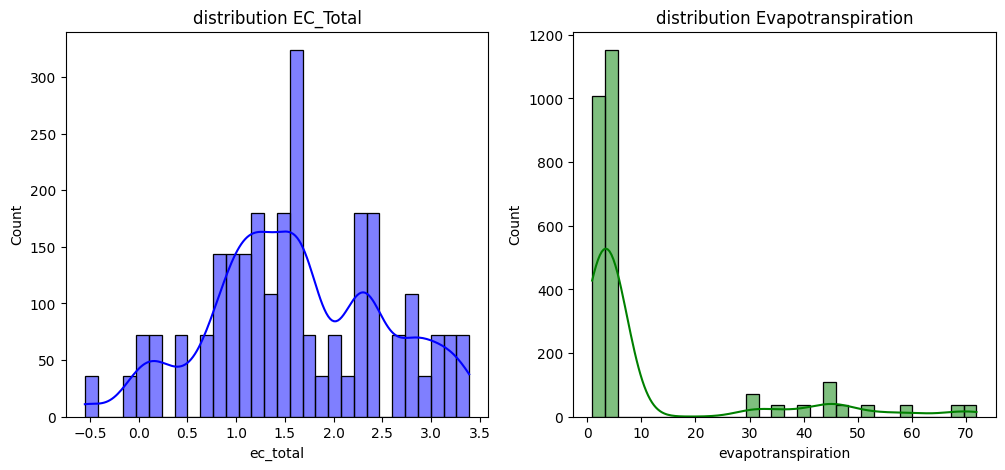

In [ ]:
# Plot the distribution of values ​​for EC_Total and ET
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df["ec_total"], kde=True, bins=30, color='blue')
plt.title("distribution EC_Total")
plt.subplot(1, 2, 2)
sns.histplot(df["evapotranspiration"], kde=True, bins=30, color='green')
plt.title("distribution Evapotranspiration")

plt.show()

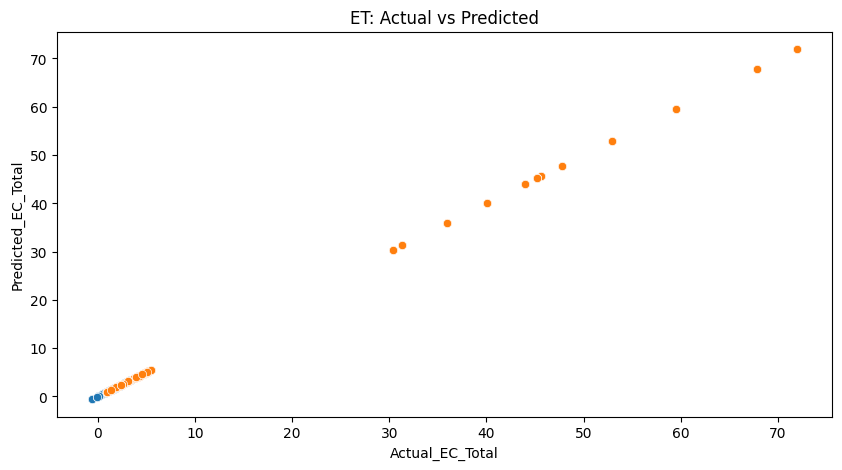

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=predictions_df["Actual_EC_Total"], y=predictions_df["Predicted_EC_Total"])
plt.title("EC_Total: Actual vs Predicted")
sns.scatterplot(x=predictions_df["Actual_ET"], y=predictions_df["Predicted_ET"])
plt.title("ET: Actual vs Predicted")
plt.show()

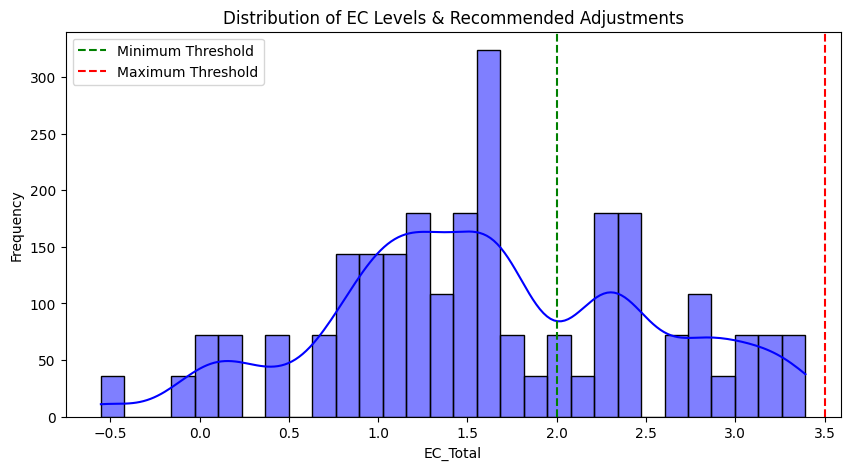

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df["ec_total"], bins=30, kde=True, color='blue')
plt.axvline(x=2.0, color='green', linestyle='--', label="Minimum Threshold")
plt.axvline(x=3.5, color='red', linestyle='--', label="Maximum Threshold")
plt.title("Distribution of EC Levels & Recommended Adjustments")
plt.xlabel("EC_Total")
plt.ylabel("Frequency")
plt.legend()
plt.show()

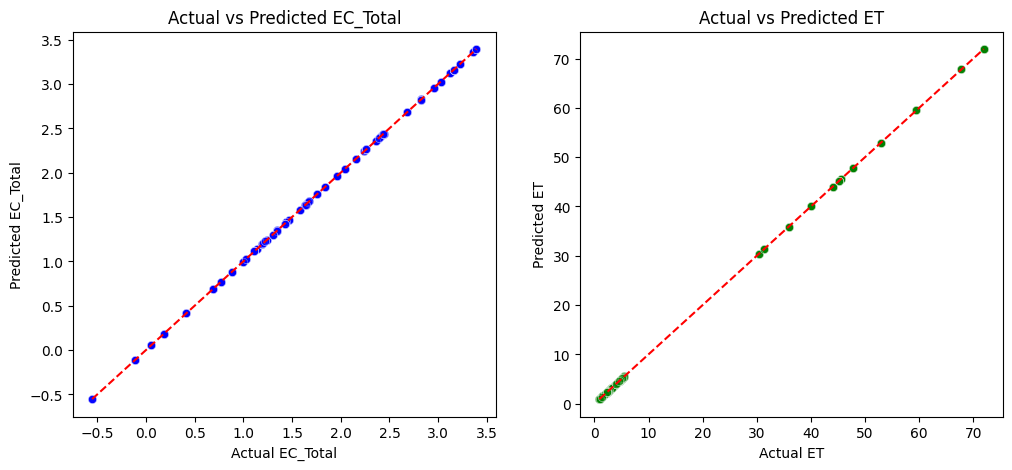

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test["EC_Total"], y=model.predict(X_test)[:, 0], color="blue", alpha=0.6)
plt.plot([min(y_test["EC_Total"]), max(y_test["EC_Total"])], [min(y_test["EC_Total"]), max(y_test["EC_Total"])], linestyle="--", color="red")
plt.title("Actual vs Predicted EC_Total")
plt.xlabel("Actual EC_Total")
plt.ylabel("Predicted EC_Total")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test["Evapotranspiration"], y=model.predict(X_test)[:, 1], color="green", alpha=0.6)
plt.plot([min(y_test["Evapotranspiration"]), max(y_test["Evapotranspiration"])], [min(y_test["Evapotranspiration"]), max(y_test["Evapotranspiration"])], linestyle="--", color="red")
plt.title("Actual vs Predicted ET")
plt.xlabel("Actual ET")
plt.ylabel("Predicted ET")

plt.show()


In [15]:
import joblib

joblib.dump(model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [17]:
pip install streamlit joblib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00


In [18]:
import streamlit as st
import joblib
import numpy as np

# تحميل النموذج
model = joblib.load("random_forest_model.pkl")

# تصميم الواجهة
st.title("🧠 توقع باستخدام Random Forest")
st.write("أدخل القيم المطلوبة وسيقوم النموذج بإعطاء التوقع.")

# إدخال البيانات
input_data = st.text_input("📝 أدخل القيم مفصولة بفاصلة (مثلاً: 5.1,3.5,1.4,0.2)")

# زر التوقع
if st.button("🔍 توقع"):
    try:
        # تحويل الإدخال إلى مصفوفة
        features = np.array([float(i) for i in input_data.split(",")]).reshape(1, -1)
        prediction = model.predict(features)

        # عرض النتيجة
        st.success(f"🔮 التوقع: {prediction[0]}")
    except Exception as e:
        st.error(f"❌ خطأ في الإدخال: {e}")


2025-03-28 23:22:42.983 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-28 23:22:43.164 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-28 23:22:43.168 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-28 23:22:43.180 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-28 23:22:43.184 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-28 23:22:43.188 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-28 23:22:43.191 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-28 23:22:43.195 Thread 'MainThread': mi